In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━

#FINAL Consolidated Code

In [ ]:
import os
import glob
import pandas as pd
from pycaret.time_series import *
import matplotlib.pyplot as plt

# Folder containing Excel files for the companies (each file has columns: Date, Close)
folder_path = "/content/companies"  # update this to your folder path

# Get list of all Excel files in the folder
file_list = glob.glob(os.path.join(folder_path, "*.xlsx"))

# List to hold the results DataFrames for each company
results_list = []

# Process each company file
for file_path in file_list:
    # Use file name (without extension) as the company name
    company_name = os.path.splitext(os.path.basename(file_path))[0]
    print(f"Processing {company_name}...")

    # Read the Excel file
    data = pd.read_excel(file_path)

    # Convert 'Date' column to datetime and set it as the index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Ensure business day frequency and fill missing values
    data = data.asfreq('B')
    data = data.fillna(method="ffill")

    # Use only the 'Close' column
    df = data[['Close']].dropna()

    # Split the data: last 7 rows for testing/validation; rest for training
    test_data = df.iloc[-7:]
    df_train = df.iloc[:-7]

    # Initialize PyCaret Time Series Experiment on training data
    exp = TSForecastingExperiment()
    exp.setup(
        data=df_train,
        target='Close',
        session_id=123,
        seasonal_period=12,
        numeric_imputation_target='linear',
        use_gpu=True
    )

    # Automatically select the best model
    best_model = exp.compare_models()

    # Forecast the next 7 business days
    future_forecast = exp.predict_model(best_model, fh=list(range(1, 8)))

    # Prepare DataFrames for forecast and real values
    forecast_df = pd.DataFrame({"Forecast": future_forecast.values.flatten()}, index=test_data.index)
    real_df = pd.DataFrame({"Real": test_data['Close'].values}, index=test_data.index)

    # Compute error as a single column using array arithmetic
    error_values = abs(forecast_df["Forecast"] - real_df["Real"]) / real_df["Real"] * 100
    error_df = pd.DataFrame(error_values, index=test_data.index, columns=["Error (%)"])

    # Determine buy/sell actions:
    # For the first forecast, compare with the last training day; then compare with previous forecast.
    forecast_values = future_forecast.values.flatten()
    actions = []
    for i in range(len(forecast_values)):
        previous_close = df_train['Close'].iloc[-1] if i == 0 else forecast_values[i - 1]
        forecasted_price = forecast_values[i]
        action = "Sell" if forecasted_price > previous_close else "Buy"
        actions.append(action)
    actions_df = pd.DataFrame({"Action": actions}, index=test_data.index)

    # Combine forecast, real, error, and actions into one DataFrame for the current company
    combined_df = pd.concat([forecast_df, real_df, error_df, actions_df], axis=1)
    # Add a column for the company name
    combined_df["Company"] = company_name
    # Reset index so that Date becomes a column
    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={"index": "Date"}, inplace=True)

    # Append the result to our list
    results_list.append(combined_df)

    # (Optional) Plot for visual check per company
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label="Historical Data", color='blue')
    plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecasted", marker='o', color='red')
    model_name = best_model.__class__.__name__
    plt.text(0.5, 0.95, f"Model: {model_name}", transform=plt.gca().transAxes, fontsize=12, ha='center')
    plt.title(f"Historical Data and 7-Day Forecast for {company_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine all company results into a single DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Write the final results to one Excel file with a single sheet containing all companies
output_filename = "combined_forecast_output.xlsx"
final_results.to_excel(output_filename, index=False)

print("Combined output saved to", output_filename)


Processing INFY...


,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1334, 1)"
5,Transformed data shape,"(1334, 1)"
6,Transformed train set shape,"(1333, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:21:31
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
naive,Naive Forecaster,0.1766,0.1382,10.7833,10.7833,0.0056,0.0057,0.0567
arima,ARIMA,0.5618,0.4397,34.3040,34.3040,0.0180,0.0179,0.3133
polytrend,Polynomial Trend Forecaster,1.0131,0.7928,61.8397,61.8397,0.0324,0.0330,0.0900
snaive,Seasonal Naive Forecaster,1.3429,1.0509,81.9667,81.9667,0.0430,0.0440,0.3633
grand_means,Grand Means Forecaster,7.7610,6.0735,473.7465,473.7465,0.2486,0.2839,0.2133


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

KeyboardInterrupt: 

#Single company

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(551, 1)"
5,Transformed data shape,"(551, 1)"
6,Transformed train set shape,"(550, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.1461,0.0991,27.6798,27.6798,0.0073,0.0073,0.2400
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.1774,0.1202,33.5823,33.5823,0.0088,0.0089,0.1367
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.2001,0.1356,37.8840,37.8840,0.0099,0.0099,0.1133
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2001,0.1356,37.8840,37.8840,0.0099,0.0099,0.1200
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.2002,0.1357,37.9140,37.9140,0.0100,0.0100,0.1233
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.2003,0.1358,37.9327,37.9327,0.0100,0.0100,0.1233
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.2003,0.1358,37.9264,37.9264,0.0100,0.0100,0.1200
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.2064,0.1399,39.0774,39.0774,0.0103,0.0103,0.1233
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2360,0.1600,44.6845,44.6845,0.0117,0.0117,0.1433
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.2601,0.1762,49.2174,49.2174,0.0129,0.0130,0.1267


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

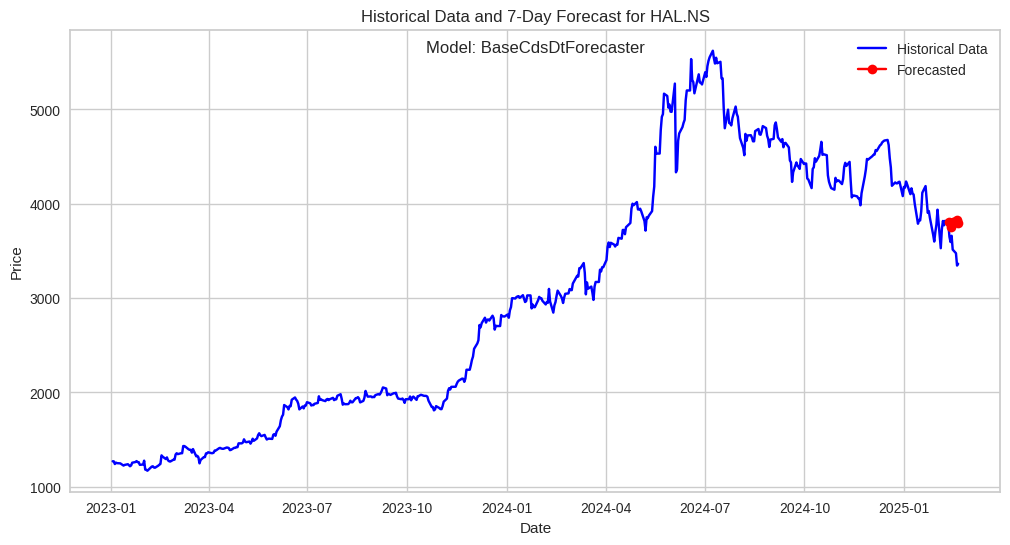


Final Forecasted Values:
                         HAL.NS
Date                          
2025-02-11 15:30:00  3811.0238
2025-02-12 15:30:00  3750.7298
2025-02-13 15:30:00  3789.3132
2025-02-14 15:30:00  3805.5675
2025-02-17 15:30:00  3818.3730
2025-02-18 15:30:00  3826.2930
2025-02-19 15:30:00  3792.4771

Real Market Values:
                       HAL.NS Action
Date                               
2025-02-11 15:30:00  3649.45   Sell
2025-02-12 15:30:00  3594.15    Buy
2025-02-13 15:30:00  3660.30   Sell
2025-02-14 15:30:00  3513.70   Sell
2025-02-17 15:30:00  3475.70   Sell
2025-02-18 15:30:00  3344.60   Sell
2025-02-19 15:30:00  3363.75    Buy

Error Percentages:
                         HAL.NS
Date                          
2025-02-11 15:30:00   4.427347
2025-02-12 15:30:00   4.356518
2025-02-13 15:30:00   3.524662
2025-02-14 15:30:00   8.306557
2025-02-17 15:30:00   9.859108
2025-02-18 15:30:00  14.402111
2025-02-19 15:30:00  12.745510


In [ ]:
import pandas as pd
from pycaret.time_series import * # ML library in Python that simplifies the process of training and deploying models
import matplotlib.pyplot as plt

# Read the Excel file containing the data
# Make sure the Excel file is in the same directory or provide the full path
data = pd.read_excel("/content/companies/HAL2.xlsx")

# Convert the 'Date' column to datetime and set it as the DataFrame index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Ensure the time series index has a business day frequency and fill missing values
data = data.asfreq('B')
data = data.fillna(method="ffill") #forward fill approach

# We'll assume this Excel file contains data for RELIANCE's CLOSE price.
ticker = "HAL.NS"  # You can change this ticker if desired.
#tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "HAL.NS", "ABBOTINDIA.NS", "BAJFINANCE.NS", "INFY.NS"]
# Select the 'Close' column and drop any missing values
df = data[['Close']].dropna() #remove missing (NaN) values from a DataFrame or Series

# Use the last 7 rows for validation (forecast horizon) and the rest for training
test_data = df.iloc[-7:]
df_train = df.iloc[:-7]

# Initialize the PyCaret Time Series Experiment with the training data
exp = TSForecastingExperiment()
exp.setup(df_train, target='Close', session_id=123, seasonal_period=12,
          numeric_imputation_target='linear', use_gpu=True)

# Compare available models and select the best-performing one
best_model = exp.compare_models()

# Forecast the next 7 business days (corresponding to the last 7 days in our data)
future_forecast = exp.predict_model(best_model, fh=list(range(1, 8)))

# Store forecast results (flattened array) for our ticker
forecast_results = {ticker: future_forecast.values.flatten()}

# Use the validation set (last 7 days) as the real market values
real_values = {ticker: test_data['Close'].values}

# Convert the forecast and real values into DataFrames for further processing
forecast_df = pd.DataFrame(forecast_results, index=test_data.index)
real_df = pd.DataFrame(real_values, index=test_data.index)

# Calculate the Mean Absolute Percentage Error (MAPE)
error_df = abs((real_df - forecast_df) / real_df) * 100

# Determine simple buy/sell actions based on forecast trends:
# For the first forecast, compare with the last training day's close.
# For subsequent forecasts, compare with the previous forecast.
actions = []
for i in range(len(forecast_results[ticker])):
    previous_close = df_train['Close'].iloc[-1] if i == 0 else forecast_results[ticker][i - 1]
    forecasted_price = forecast_results[ticker][i]
    action = "Sell" if forecasted_price > previous_close else "Buy"
    actions.append([ticker, forecast_df.index[i], action])

actions_df = pd.DataFrame(actions, columns=["Stock", "Date", "Action"])

# Add the 'Action' column to the real values DataFrame
real_df['Action'] = actions_df['Action'].values

# Save outputs for further analysis
forecast_df.to_csv("forecasted_values.csv")
real_df.to_csv("real_values.csv")
error_df.to_csv("error_percentages.csv")

# Plot the historical data along with the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="Historical Data", color='blue')
plt.plot(forecast_df.index, forecast_df[ticker], label="Forecasted", marker='o', color='red')

# Display the name of the best model used
model_name = best_model.__class__.__name__
plt.text(0.5, 0.95, f"Model: {model_name}", transform=plt.gca().transAxes,
         fontsize=12, ha='center')

plt.title(f"Historical Data and 7-Day Forecast for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print final outputs to the console
print("\nFinal Forecasted Values:\n", forecast_df)
print("\nReal Market Values:\n", real_df)
print("\nError Percentages:\n", error_df)


## SINGLE COMPANY WITH COMBINED EXCEL OUTPUT

In [ ]:
import pandas as pd
from pycaret.time_series import *
import matplotlib.pyplot as plt

# Read the Excel file containing the data
# Adjust the file path as needed
data = pd.read_excel("/content/companies/INFY.xlsx")

# Convert the 'Date' column to datetime and set it as the DataFrame index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Ensure the time series index has a business day frequency and fill missing values
data = data.asfreq('B')
data = data.fillna(method="ffill")

# We'll assume this Excel file contains data for INFY's CLOSE price.
ticker = "INFY.NS"  # Adjust ticker if needed.

# Select the 'Close' column and drop any missing values
df = data[['Close']].dropna()

# Use the last 7 rows for validation (forecast horizon) and the rest for training
test_data = df.iloc[-7:]
df_train = df.iloc[:-7]

# Initialize the PyCaret Time Series Experiment with the training data
exp = TSForecastingExperiment()
exp.setup(df_train, target='Close', session_id=123, seasonal_period=12,
          numeric_imputation_target='linear', use_gpu=True)

# Compare available models and select the best-performing one
best_model = exp.compare_models()

# Forecast the next 7 business days (corresponding to the last 7 days in our data)
future_forecast = exp.predict_model(best_model, fh=list(range(1, 8)))

# Store forecast results (flattened array) and rename column to "Forecast"
forecast_results = {ticker: future_forecast.values.flatten()}
forecast_df = pd.DataFrame(forecast_results, index=test_data.index)
forecast_df.rename(columns={ticker: "Forecast"}, inplace=True)

# Use the validation set (last 7 days) as the real market values
real_values = {ticker: test_data['Close'].values}
real_df = pd.DataFrame(real_values, index=test_data.index)
real_df.rename(columns={ticker: "Real"}, inplace=True)

# Calculate the Mean Absolute Percentage Error (MAPE)
error_values = abs(forecast_df["Forecast"] - real_df["Real"]) / real_df["Real"] * 100
error_df = pd.DataFrame(error_values, index=test_data.index, columns=["Error (%)"])

# Determine simple buy/sell actions based on forecast trends:
# For the first forecast, compare with the last training day's close.
# For subsequent forecasts, compare with the previous forecast.
actions = []
forecast_array = forecast_df["Forecast"].values
for i in range(len(forecast_array)):
    previous_close = df_train['Close'].iloc[-1] if i == 0 else forecast_array[i - 1]
    forecasted_price = forecast_array[i]
    action = "Sell" if forecasted_price > previous_close else "Buy"
    actions.append(action)
actions_df = pd.DataFrame({"Action": actions}, index=test_data.index)

# Combine forecast, real, error, and actions into one single DataFrame
combined_df = pd.concat([forecast_df, real_df, error_df, actions_df], axis=1)
combined_df.reset_index(inplace=True)
combined_df.rename(columns={"index": "Date"}, inplace=True)

# Save the combined results to a single Excel workbook (one sheet)
output_filename = "combined_forecast_output.xlsx"
combined_df.to_excel(output_filename, index=False)

# Plot the historical data along with the forecasted values for visual reference
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="Historical Data", color='blue')
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecasted", marker='o', color='red')
model_name = best_model.__class__.__name__
plt.text(0.5, 0.95, f"Model: {model_name}", transform=plt.gca().transAxes, fontsize=12, ha='center')
plt.title(f"Historical Data and 7-Day Forecast for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print final outputs to the console
print("\nCombined Forecast Output:\n", combined_df)


#FINAL CODE (All 7 companies with combined excel output for comparision and dashboard)

In [ ]:
import os  # This helps us work with files and folders on the computer
import glob  # This helps us find all files in a folder that match a pattern (like all .xlsx files)
import pandas as pd  # This is a tool to handle tables and data easily
from pycaret.time_series import *  # This is a tool for predicting future values using past data
import matplotlib.pyplot as plt  # This helps us draw graphs and charts

# Step 1: Set the folder where all company data files are stored
folder_path = "/content/companies"  # This is the location of our Excel files

# Step 2: Find all Excel files in the folder
file_list = glob.glob(os.path.join(folder_path, "*.xlsx"))  # This collects all files ending in .xlsx (Excel files)

# Step 3: Create an empty list to store results for each company
results_list = []

# Step 4: Loop through each company file and process it
for file_path in file_list:
    # Get the company name from the file name (without ".xlsx")
    company_name = os.path.splitext(os.path.basename(file_path))[0]
    print(f"Processing {company_name}...")  # Show which company is being processed

    # Read the Excel file into a table (DataFrame)
    data = pd.read_excel(file_path)

    # Convert the 'Date' column into a date format so the computer understands it
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)  # Set 'Date' as the index (like row labels)

    # Ensure data follows business days (Monday to Friday) and fill missing values if any
    data = data.asfreq('B')  # 'B' stands for Business Days (no weekends)
    data = data.fillna(method="ffill")  # Fill missing values using previous available data

    # Keep only the 'Close' price column (which tells us the stock price at the end of each day)
    df = data[['Close']].dropna()  # Remove empty values (if any)

    # Step 5: Split data into training and testing
    test_data = df.iloc[-7:]  # Last 7 rows are saved for testing (future prediction check)
    df_train = df.iloc[:-7]  # Everything else is used for training (learning past trends)

    # Step 6: Start a forecasting experiment using PyCaret
    exp = TSForecastingExperiment()  # Create a forecasting experiment setup
    exp.setup(
        data=df_train,  # Use training data
        target='Close',  # The column we want to predict (stock price)
        session_id=123,  # Ensures results are the same every time by controlling randomness
        seasonal_period=12,  # Assumes stock prices follow a repeating cycle every 12 time periods
        numeric_imputation_target='linear',  # Fills missing stock prices by estimating values in a straight line
        use_gpu=True  # Use GPU (if available) to speed up processing
    )

    # Step 7: Find the best prediction model automatically
    best_model = exp.compare_models()

    # Step 8: Forecast the next 7 days (predict future stock prices)
    future_forecast = exp.predict_model(best_model, fh=list(range(1, 8)))

    # Step 9: Create a table to store predictions, real values, and errors
    forecast_df = pd.DataFrame({"Forecast": future_forecast.values.flatten()}, index=test_data.index)
    real_df = pd.DataFrame({"Real": test_data['Close'].values}, index=test_data.index)

    # Step 10: Calculate the error percentage
    error_values = abs(forecast_df["Forecast"] - real_df["Real"]) / real_df["Real"] * 100
    error_df = pd.DataFrame(error_values, index=test_data.index, columns=["Error (%)"])

    # Step 11: Decide if we should Buy or Sell
    forecast_values = future_forecast.values.flatten()  # Get the forecasted prices
    actions = []
    for i in range(len(forecast_values)):
        previous_close = df_train['Close'].iloc[-1] if i == 0 else forecast_values[i - 1]
        # Compare with last known price (first time) or previous forecast
        forecasted_price = forecast_values[i]  # Get the predicted price
        action = "Sell" if forecasted_price > previous_close else "Buy"  # Decide action
        actions.append(action)
    actions_df = pd.DataFrame({"Action": actions}, index=test_data.index)  # Store actions

    # Step 12: Combine all results into a single table
    combined_df = pd.concat([forecast_df, real_df, error_df, actions_df], axis=1)
    combined_df["Company"] = company_name  # Add a column with the company name
    combined_df.reset_index(inplace=True)  # Reset index so 'Date' becomes a column again
    combined_df.rename(columns={"index": "Date"}, inplace=True)  # Rename index to 'Date'

    # Step 13: Add this company's result to the final list
    results_list.append(combined_df)

    # Step 14: Draw a graph to visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label="Historical Data", color='blue')  # Actual past prices
    plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecasted", marker='o', color='red')  # Predicted prices
    model_name = best_model.__class__.__name__  # Get the model name used for forecasting
    plt.text(0.5, 0.95, f"Model: {model_name}", transform=plt.gca().transAxes, fontsize=12, ha='center')  # Show model name
    plt.title(f"Historical Data and 7-Day Forecast for {company_name}")  # Set graph title
    plt.xlabel("Date")  # Label x-axis
    plt.ylabel("Price")  # Label y-axis
    plt.legend()  # Show legend
    plt.grid(True)  # Add grid lines
    plt.show()  # Display the graph

# Step 15: Merge all company results into a single final table
final_results = pd.concat(results_list, ignore_index=True)

# Step 16: Save all results into a single Excel file
output_filename = "combined_forecast_output.xlsx"
final_results.to_excel(output_filename, index=False)  # Save as Excel file

# Step 17: Print a message that the process is finished
print("Combined output saved to", output_filename)
